### Data (GEOS16 ,GK2A)

#### GEOS16

Channel 2: The "Red" band
The centralized wavelength for this band is 0.64 µm (micrometers).

Channel 5: The "Snow/Ice" band
The centralized wavelength for this band is 1.61 µm (micrometers).

Channel 13: The "Clean" Infrared band
The centralized wavelength for this band is 10.3 µm (micrometers).

Channel 15: The "Dirty" Infrared band
The centralized wavelength for this band is 12.3 µm (micrometers).

#### GK2A

2024.07.16 
 


In [204]:
import os
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import cv2

def get_vi_bt(nc_file, is_fd=None):
    gain =0.154856294393539 #vi006
    offset =  -6.19424438476562 #vi006

    rad_to_alb= 0.001924484 #Radiance_to_Albedo_c
    rad_to_alb *= 100

    ncfile = netCDF4.Dataset(nc_file, 'r', format='netcdf4')
    ipixel = ncfile.variables['image_pixel_values'][:]
    if is_fd is not None:
        ipixel[ipixel==32768] = (np.sum(np.unique(ipixel))-32768)/(len(np.unique(ipixel))-1)

    data = gain * ipixel + offset
    data = data * rad_to_alb

    ## to numpy array
    data = np.asarray(data)
    #data = transform.resize(data, (data.shape[0]/4, data.shape[1]/4), preserve_range=True)
    #data = (data + 10 - 65.5) / 65.5   #VI006 -10 ~ 121

    return data/65.5

def get_wv_bt(nc_file, is_fd=None):
    gain = -0.0108914673328399 #WV063
    offset = 44.1777038574218 #WV063
    c0 = -1.76279494011147
    c1 = 1.00414910562278
    c2 = -9.83310914319385e-07

    cval = 299792458.0
    kval =1.3806488e-23
    hval =  6.62606957e-34

    wv_wave =6.21
    wn = (10000 /wv_wave) * 100
    e1 = (2 * hval * cval * cval) * np.power(wn, 3)

    ncfile = netCDF4.Dataset(nc_file, 'r', format='netcdf4')
    ipixel = ncfile.variables['image_pixel_values'][:]
    if is_fd is not None:
        ipixel[ipixel==32768] = (np.sum(np.unique(ipixel))-32768)/(len(np.unique(ipixel))-1)
    data = gain * ipixel + offset
    e2 = (data * 1e-5)
    t_eff = ((hval * cval / kval) * wn) / np.log((e1 / e2) + 1)
    bt_data = c0 + c1 * t_eff + c2 * t_eff * t_eff

    gsics_data = bt_data
    gsics_data = np.asarray(gsics_data)
    #gsics_data = (gsics_data - 134 - 98.5) / 98.5   #wv063 134 ~ 331

    return gsics_data

def get_ir_bt(nc_file, is_fd=None):
    gain = -0.0198196955025196 #IR105
    offset = 161.580139160156  #IR105
    c0 = -0.142866448475177
    c1 = 1.00064069572049
    c2 = -5.50443294960498e-07
    cval = 299792458.0
    kval =1.3806488e-23
    hval =  6.62606957e-34
    ir_wave =10.35
    wn = (10000 /ir_wave) * 100
    e1 = (2 * hval * cval * cval) * np.power(wn, 3)

    rad_slope =  0.9999575018882751
    rad_offset =  0.14451110363006592

    ncfile = netCDF4.Dataset(nc_file, 'r', format='netcdf4')
    ipixel = ncfile.variables['image_pixel_values'][:]
    if is_fd is not None:
        ipixel[ipixel==32768] = (np.sum(np.unique(ipixel))-32768)/(len(np.unique(ipixel))-1)

    data = gain * ipixel + offset
    e2 = (data * 1e-5)
    t_eff = ((hval * cval / kval) * wn) / np.log((e1 / e2) + 1)
    bt_data = c0 + c1 * t_eff + c2 * t_eff * t_eff

    gsics_data = (bt_data - rad_offset) / rad_slope

    gsics_data = np.asarray(gsics_data)
    #gsics_data = (gsics_data - 100 - 115.025) / 115.025   #IR105 100 ~ 330.05

    return gsics_data
    
def bytescale(data_arr,vmin,vmax):
    assert(vmin < vmax)
    DataImage = np.round((data_arr - vmin) / (vmax - vmin) * 255.9999)
    DataImage[DataImage < 0] = 0
    DataImage[DataImage > 255] = 255
    return DataImage.astype(np.uint8)

In [205]:
ch02 = get_vi_bt("./gk2a_ami_le1b_vi006_ko005lc_202407160500.nc")
ch05 = get_vi_bt("./gk2a_ami_le1b_nr016_ko020lc_202407160500.nc")
ch13 = get_ir_bt("./gk2a_ami_le1b_ir105_ko020lc_202407160500.nc")
ch15 = get_ir_bt("./gk2a_ami_le1b_ir123_ko020lc_202407160500.nc")

In [206]:
ch02 = bytescale(ch02, ch02.min(), ch02.max())
ch05 = bytescale(ch05, ch05.min(), ch05.max())
ch13 = bytescale(ch13, ch13.min(), ch13.max())
ch15 = bytescale(ch15, ch15.min(), ch15.max())

In [207]:
ch05 = cv2.resize(ch05, (3600, 3600))
ch13 = cv2.resize(ch13, (3600, 3600))
ch15 = cv2.resize(ch15, (3600, 3600))
concat_result = np.stack([ch02, ch05, ch13, ch15], axis=0)

concat_result = concat_result/255.
concat_result = torch.tensor(concat_result)
concat_result = concat_result.unsqueeze(dim=0)

In [208]:
import torch

In [209]:
from models.unet import UNet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = UNet(n_channels=4, n_classes=1)
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    
checkpoint = torch.load('./checkpoint/10.pth')
net.load_state_dict(checkpoint)

<All keys matched successfully>

In [210]:
output = net(concat_result.float().to(device))

In [211]:
output = output.squeeze(0).squeeze(0).cpu().detach().numpy()
output = output*50
np.save('pred',output)
ch13 = ch13[::4, ::4]

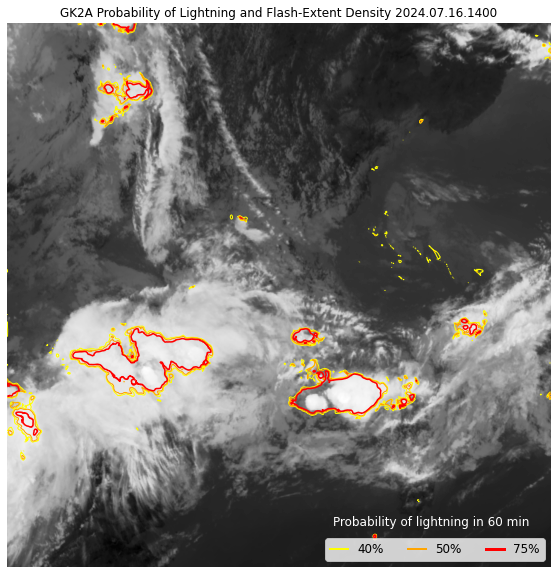

In [212]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import netCDF4

fed = output

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
plt.axis('off')

sat = plt.imshow(np.squeeze(ch13), cmap=plt.get_cmap('Greys'))

#im = plt.imshow(fed, vmin=0, vmax=100, alpha=0.5, cmap='viridis')  # Adjust alpha for transparency

colors = ['yellow', 'orange', 'red']
linewidths = [1, 1, 1.5]
levels = [0.4, 0.5, 0.75]
labels = [str(int(l * 100)) + '%' for l in levels]

plt.contour(fed, levels=levels, colors=colors, linewidths=linewidths)

custom_lines = [Line2D([0], [0], color=c, lw=lw * 2) for c, lw in zip(colors, linewidths)]
leg = plt.legend(custom_lines, labels, fontsize=12, loc="lower right", handlelength=1.5, ncol=3)
prob_label = "Probability of lightning in 60 min"
ctext = plt.text(0.6, 0.075, prob_label, fontsize=12, color="white", transform=ax.transAxes)

plt.colorbar(im, orientation='horizontal', label='Flash-extent density [flashes/(5 min)]', pad=0.03)

plt.title(f'GK2A Probability of Lightning and Flash-Extent Density 2024.07.16.1400')

plt.show()
